<h1>Model training<h1>



Mounten van de google drive, het importeren van fastai en het uitpakken van de foto's gebeurd in de eerste stap.

In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 12.8 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 189 kB 45.0 MB/s 
     |████████████████████████████████| 1.2 MB 49.2 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 314 kB/s 
Mounted at /content/gdrive


In [5]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!unzip data.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: data/federal/federal321.png  
  inflating: data/federal/federal322.png  
  inflating: data/federal/federal323.png  
  inflating: data/federal/federal324.png  
  inflating: data/federal/federal325.png  
  inflating: data/federal/federal326.png  
  inflating: data/federal/federal327.png  
  inflating: data/federal/federal328.png  
  inflating: data/federal/federal329.png  
  inflating: data/federal/federal33.png  
  inflating: data/federal/federal330.png  
  inflating: data/federal/federal331.png  
  inflating: data/federal/federal332.png  
  inflating: data/federal/federal333.png  
  inflating: data/federal/federal334.png  
  inflating: data/federal/federal335.png  
  inflating: data/federal/federal336.png  
  inflating: data/federal/federal337.png  
  inflating: data/federal/federal338.png  
  inflating: data/federal/federal339.png  
  inflating: data/federal/federal34.png  
  inflating: data/federal/federal340.png  
  

Het tonen van 1 foto om te zien of het pad goed is en de data goed geladen is.

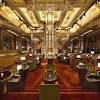

In [4]:
from PIL import Image
path = '/content/data/'
im = Image.open(path + 'art deco/art deco0.png')
im.to_thumb(128,128)

In [5]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#9053) [Path('/content/data/tudor/tudor479.png'),Path('/content/data/tudor/tudor653.png'),Path('/content/data/tudor/tudor114.png'),Path('/content/data/tudor/tudor665.png'),Path('/content/data/tudor/tudor572.png'),Path('/content/data/tudor/tudor184.png'),Path('/content/data/tudor/tudor285.png'),Path('/content/data/tudor/tudor134.png'),Path('/content/data/tudor/tudor499.png'),Path('/content/data/tudor/tudor581.png')...]

Nakijken of er geen corrupte files tussen staan

In [6]:
failed = verify_images(filenames)
failed

(#0) []

# **DataLoaders**


Quick summary of the doc:

In [6]:
??DataLoaders

# **Fastai data block API**


In [8]:
architecture = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
doc(DataBlock)

In [11]:
dls = architecture.dataloaders(path)

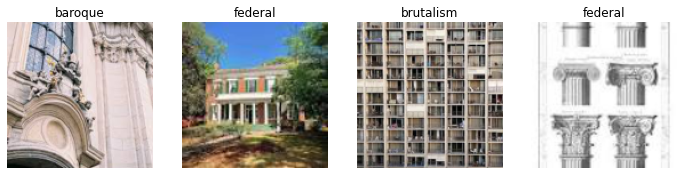

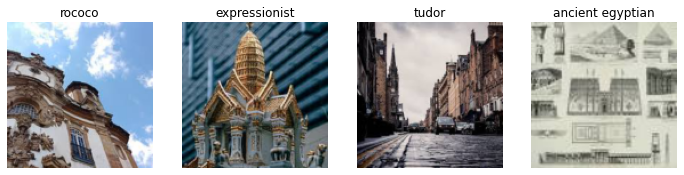

In [12]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Tonen van 8 foto's 4 per row die ge resized zijn

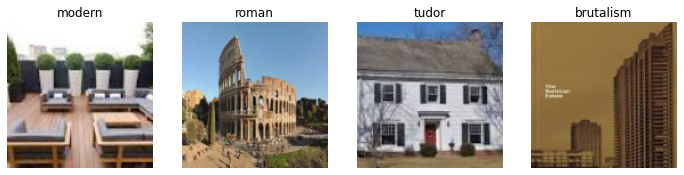

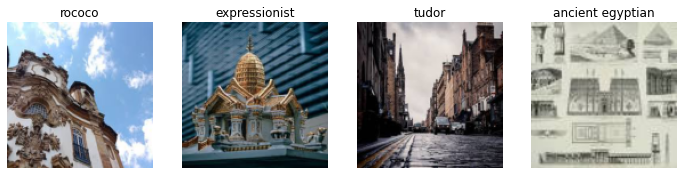

In [13]:
architecture = architecture.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

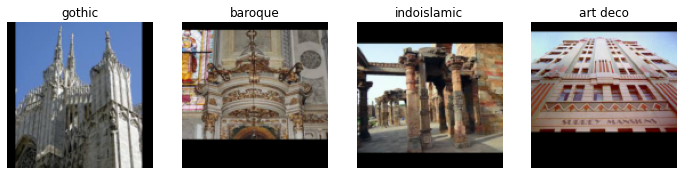

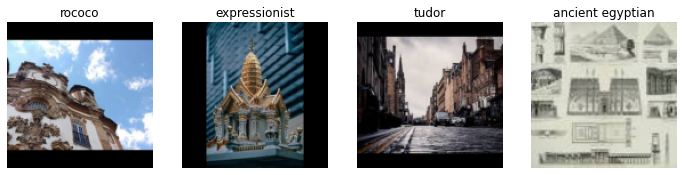

In [14]:
architecture = architecture.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

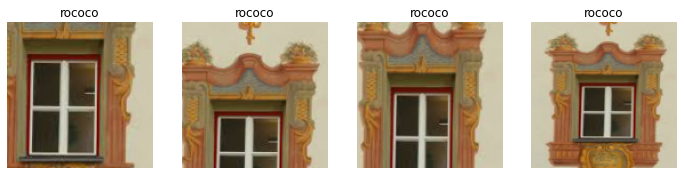

In [15]:
architecture = architecture.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
# the unique=True piece here is just to force our sanity check to give us the same image over and over again, 
# ofcourse each time with the random transform applied to it

Het trainen van het model kan eindelijk gebeuren. We hebben gekozen voor maar 3 epochs aangezien vanaf 4 epochs de data biased werd.

In [18]:
our_out_of_the_box_model = cnn_learner(dls, resnet50, metrics=error_rate)
our_out_of_the_box_model.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.717485,2.028056,0.563536,01:06


epoch,train_loss,valid_loss,error_rate,time
0,1.978235,1.638090,0.492818,01:27
1,1.549505,1.449475,0.427624,01:27
2,1.122805,1.357920,0.402762,01:28


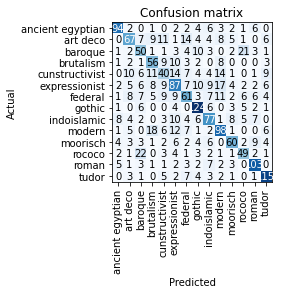

In [19]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

# Google teachable machine verwarringsmatrix 


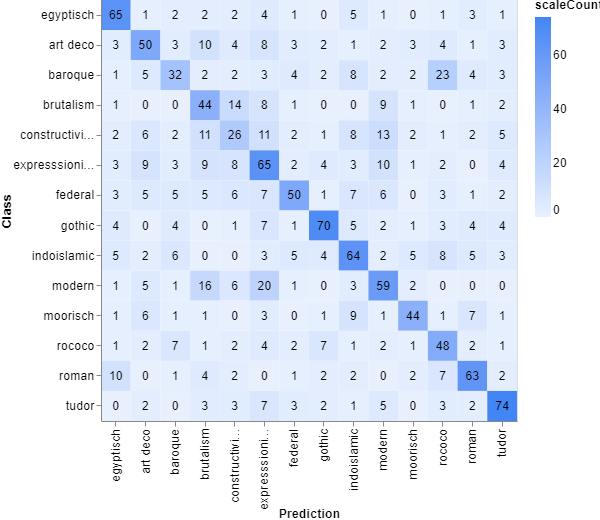

In [20]:
#interp.plot_top_losses(2, nrows=1)

def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)



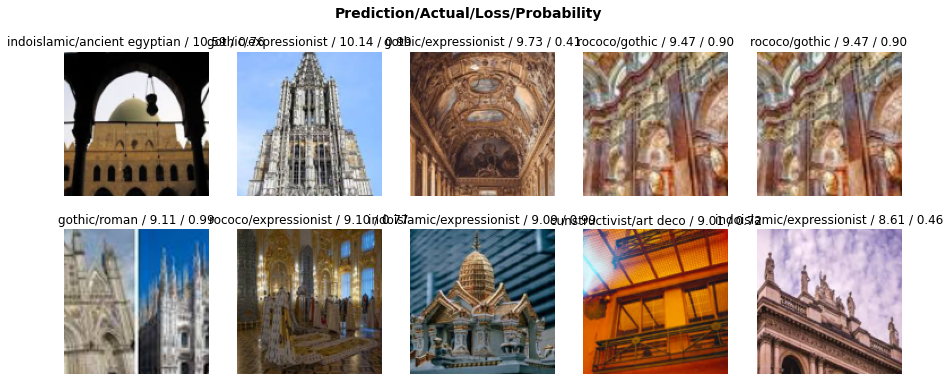

In [21]:
plot_top_losses_fix(interp, 10, nrows=2)

In [22]:
# saving our model, by default in a folder called 'models'.
our_out_of_the_box_model.save('good_model')
#creating an serialized pickle object of our model, the export.pkl file
our_out_of_the_box_model.export()

In [22]:
ls

data/  data.zip  export.pkl  gdrive/  models/  sample_data/


# **Loading a model & inference:**

In [24]:
our_out_of_the_box_model_inference = load_learner('export.pkl')
# let's test our model on an image
our_out_of_the_box_model_inference.predict('/content/data/modern/modern101.png')
# this will return the predicted category, the index of this predicted category, and the probabilities of each category

('expressionist',
 TensorBase(5),
 TensorBase([4.7753e-03, 2.5152e-02, 5.1793e-04, 4.0738e-02, 4.2338e-03, 6.1465e-01, 4.5408e-02, 2.2867e-03, 9.1173e-03, 2.5046e-01, 6.2986e-04, 5.1209e-04, 1.3096e-03, 2.1098e-04]))

In [ ]:
our_out_of_the_box_model_inference.dls.vocab

________________________________________________________________________________________________________________________________________________________________

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 189 kB 45.7 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 36.0 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 286 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
!unzip data.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: data/federal/federal321.png  
  inflating: data/federal/federal322.png  
  inflating: data/federal/federal323.png  
  inflating: data/federal/federal324.png  
  inflating: data/federal/federal325.png  
  inflating: data/federal/federal326.png  
  inflating: data/federal/federal327.png  
  inflating: data/federal/federal328.png  
  inflating: data/federal/federal329.png  
  inflating: data/federal/federal33.png  
  inflating: data/federal/federal330.png  
  inflating: data/federal/federal331.png  
  inflating: data/federal/federal332.png  
  inflating: data/federal/federal333.png  
  inflating: data/federal/federal334.png  
  inflating: data/federal/federal335.png  
  inflating: data/federal/federal336.png  
  inflating: data/federal/federal337.png  
  inflating: data/federal/federal338.png  
  inflating: data/federal/federal339.png  
  inflating: data/federal/federal34.png  
  inflating: data/federal/federal340.png  
  

In [10]:
Gebouwen = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # the line of code below is just using Regular Expressions to link a file to a label
    # the label, the breed of the pet, is in the filename, that's why we need a re to extract it as the label 
    get_y=parent_label,
      # now let's also add some awesome augmentation (presizing) into the mix as well
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [11]:
path = '/content/data/'
dls = Gebouwen.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


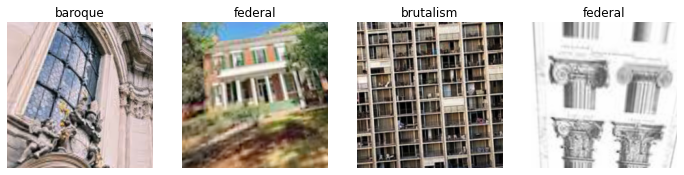

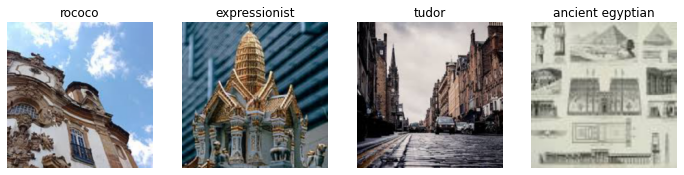

In [12]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

In [13]:
alex_model = cnn_learner(dls, alexnet, metrics=error_rate)
alex_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.805020,1.933728,0.581768,01:06


epoch,train_loss,valid_loss,error_rate,time
0,2.210030,1.709460,0.538122,01:11


In [14]:
vgg16_model = cnn_learner(dls, vgg16_bn, metrics=error_rate)
vgg16_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.674296,1.756594,0.514917,07:04


epoch,train_loss,valid_loss,error_rate,time
0,1.863627,1.471575,0.448619,09:51


In [15]:
resnet50_model = cnn_learner(dls, resnet50, metrics=error_rate)
resnet50_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.472112,1.844266,0.517127,03:08


epoch,train_loss,valid_loss,error_rate,time
0,1.725762,1.401489,0.427624,04:01


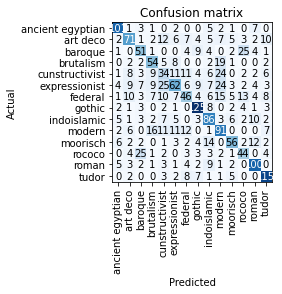

In [16]:
interp = ClassificationInterpretation.from_learner(resnet50_model)
interp.plot_confusion_matrix()

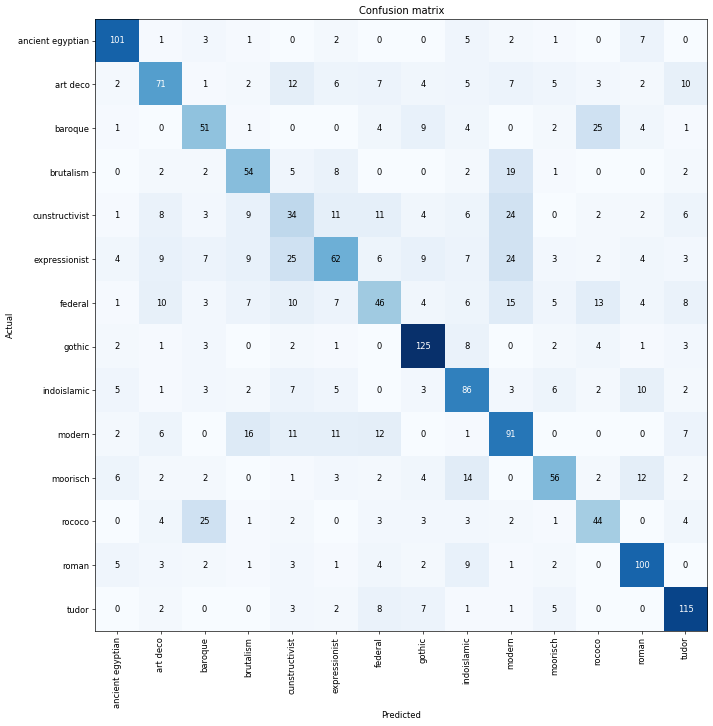

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

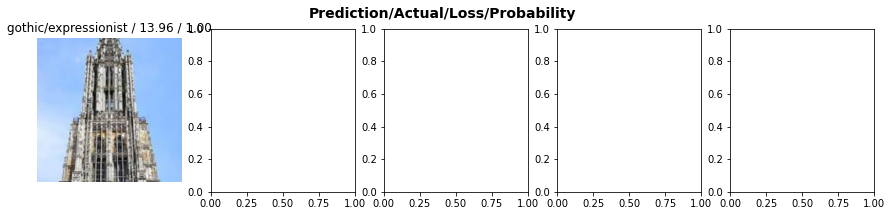

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
interp.most_confused(min_val=5)

[('baroque', 'rococo', 25),
 ('expressionist', 'cunstructivist', 25),
 ('rococo', 'baroque', 25),
 ('cunstructivist', 'modern', 24),
 ('expressionist', 'modern', 24),
 ('brutalism', 'modern', 19),
 ('modern', 'brutalism', 16),
 ('federal', 'modern', 15),
 ('moorisch', 'indoislamic', 14),
 ('federal', 'rococo', 13),
 ('art deco', 'cunstructivist', 12),
 ('modern', 'federal', 12),
 ('moorisch', 'roman', 12),
 ('cunstructivist', 'expressionist', 11),
 ('cunstructivist', 'federal', 11),
 ('modern', 'cunstructivist', 11),
 ('modern', 'expressionist', 11),
 ('art deco', 'tudor', 10),
 ('federal', 'art deco', 10),
 ('federal', 'cunstructivist', 10),
 ('indoislamic', 'roman', 10),
 ('baroque', 'gothic', 9),
 ('cunstructivist', 'brutalism', 9),
 ('expressionist', 'art deco', 9),
 ('expressionist', 'brutalism', 9),
 ('expressionist', 'gothic', 9),
 ('roman', 'indoislamic', 9),
 ('brutalism', 'expressionist', 8),
 ('cunstructivist', 'art deco', 8),
 ('federal', 'tudor', 8),
 ('gothic', 'indoislam

In [20]:
resnet34_overtrain = cnn_learner(dls, resnet34, metrics=error_rate)
resnet34_overtrain.fine_tune(1, base_lr=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.770360,2.862664,0.675691,02:14


epoch,train_loss,valid_loss,error_rate,time
0,2.371486,1.996122,0.666851,02:58


ValueError: ignored

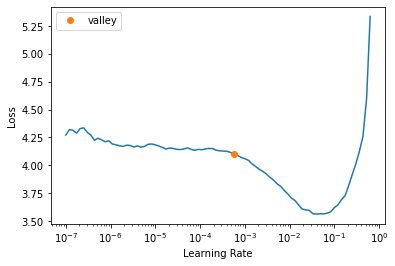

In [21]:
resnet34_just_right = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = resnet34_just_right.lr_find()

In [22]:
print(f"Steepest point: {lr_steep:.2e}")

NameError: ignored

In [23]:
resnet_adv = cnn_learner(dls, resnet34, metrics=error_rate)
resnet_adv.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.437516,1.715741,0.524862,02:15
1,1.795231,1.398267,0.445304,02:15
2,1.446647,1.335266,0.426519,02:15


In [24]:
resnet_adv.unfreeze()

SuggestedLRs(valley=6.918309736647643e-06)

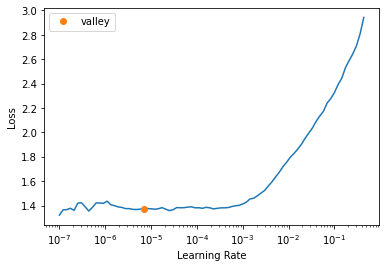

In [25]:
resnet_adv.lr_find()

In [26]:
resnet_adv.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.347293,1.317582,0.426519,02:58
1,1.307090,1.291218,0.417680,02:58
2,1.233766,1.257759,0.403867,02:59
3,1.197929,1.252270,0.404420,02:58
4,1.155953,1.242715,0.397238,02:58
5,1.140114,1.243137,0.399448,02:58


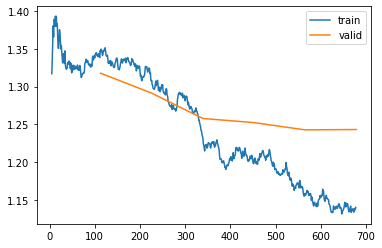

In [27]:
resnet_adv.recorder.plot_loss()

In [28]:
resnet_really_adv = cnn_learner(dls, resnet34, metrics=error_rate)
resnet_really_adv.fit_one_cycle(3, 3e-3)
resnet_really_adv.unfreeze()
resnet_really_adv.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.513052,1.757048,0.529834,02:15
1,1.806646,1.416206,0.450276,02:15
2,1.482229,1.352025,0.431492,02:15


epoch,train_loss,valid_loss,error_rate,time
0,1.363296,1.339695,0.425414,02:59
1,1.334887,1.314745,0.422099,02:58
2,1.276881,1.293794,0.412707,02:59
3,1.229483,1.270540,0.399448,02:59
4,1.163592,1.255766,0.401105,02:59
5,1.114536,1.233230,0.400000,02:58
6,1.074935,1.237986,0.396133,02:59
7,1.008424,1.218419,0.387293,02:59
8,0.966141,1.223673,0.385635,02:59
9,0.958188,1.211301,0.386188,02:58


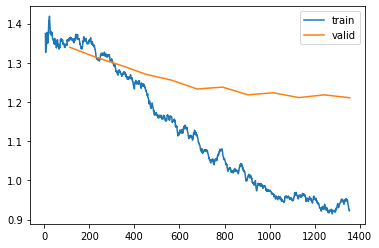

In [29]:
resnet_really_adv.recorder.plot_loss()

In [30]:
from fastai.callback.fp16 import *
resnet_adv_tweaked = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
resnet_adv_tweaked.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,2.636188,1.790179,0.516575,02:49
1,2.122864,1.683197,0.476796,02:49
2,1.761852,1.465484,0.447514,02:49


epoch,train_loss,valid_loss,error_rate,time
0,1.366812,1.381606,0.411050,03:45
1,1.273490,1.345081,0.403867,03:44
2,1.041093,1.239144,0.366851,03:45
3,0.715665,1.202735,0.344751,03:44
4,0.473628,1.200704,0.336464,03:45
5,0.333806,1.200814,0.330387,03:45


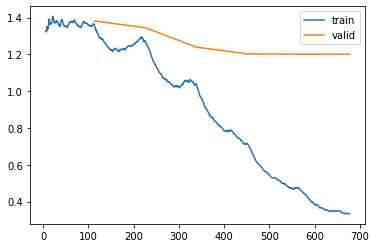

In [31]:
resnet_adv_tweaked.recorder.plot_loss()

In [33]:
resnet_really_adv.export()